In [ ]:
! pip install brian2

In [ ]:
from brian2 import *
%matplotlib inline
from scipy.signal import find_peaks
from time import time

In [ ]:
from ipywidgets import interact_manual, FloatSlider, interact
#Constants
i_const = 160*pA
C = 100*pF; gL = 12*nS; EL = -60*mV; VT = -50*mV; 
DeltaT = 2*mV; tauw = 130*ms; a = -11*nS;
tau_s = 1*ms; ks= 0.3*nA; ss = 125; ds = 3; hs = -0.045; 
I0 = 1*nA; V0 = 1*volt;
Dn = 0.8; tau_n = 25*Hz; 
epsilon_c = 0.04; tau_c = 10*ms; 
C1 = 0.13; C2 = 0.9; C3 = 0.004; C4 = 2/epsilon_c
tausm = 100*ms; ssm = 100; hsm = 0.45; dsm = 3;
tauGm = 5*tausm; sgm = ssm; hgm = 0.5; dgm = 3;

z0 = 2*ds/(1+2*ds+exp(-2*ss*(-0.015)))
print('z0 = ',z0)
eqs1 = '''
        I = i_const*int(t > 50*ms)*int(t < 500*ms) : amp
        dv1/dt = (gL*(EL-v1)+gL*DeltaT*exp((v1-VT)/DeltaT) - w1 + I + (I0-gamma)*gm)/C: volt
        dw1/dt=(a*(v1-EL)-w1)/tauw : amp
        gm : 1 (linked)
        
       '''
eqs2 = '''dv2/dt = (gL*(EL-v2)+gL*DeltaT*exp((v2-VT)/DeltaT) - w2 + I_syn + I_glion)/C : volt
          dw2/dt=(a*(v2-EL)-w2)/tauw : amp
          dz/dt = (1/tau_s)*((1+tanh(ss*((v_inp/V0)-hs)))*(1 - z) - z/ds) : 1
          I_syn = (ks - delta*Gm)*(z-z0) : amp
          I_glion = gamma*Gm : amp
          dGm/dt = (1/tauGm)*((1 + tanh(sgm*(c - hgm)))*(1-Gm)- Gm/dgm) : 1
          dc/dt = (1/tau_c)*(- c - C4*((C1*c*c/(1+c*c)) - (ce*ce/(1+ce*ce))*((c**4)/(C2**4 + c**4)) - C3*ce) + r + alpha*w2 + beta*Sm) : 1 
          dce/dt = (1/(tau_c*epsilon_c))*((C1*c*c/(1+c*c)) - (ce*ce/(1+ce*ce))*((c**4)/(C2**4 + c**4)) - C3*ce) : 1
          dSm/dt = (1/tausm)*((1 + tanh(ssm*(z - hsm)))*(1-Sm)-Sm/dsm) : 1
          v_inp : volt (linked)
      '''

z0 =  0.1211605190692803


In [ ]:
run_time = 1500*ms

In [ ]:
#Définition de la synapse  
def synapse_plot(r,Alpha,beta,Gamma,delta,i):
    #Initialization
    defaultclock.dt = 0.01*ms
    alpha = Alpha*amp**(-1); 
    gamma = Gamma*nA;
    delta = delta*nA
    #PRE-SYNAPTIC NEURON
    neuron1 = NeuronGroup(1, eqs1, threshold='v1 > -30*mV', reset='v1=-70*mV; w1 += 30*pA', method = "euler")
    #initial values
    neuron1.v1 = EL
    neuron1.w1 = 0*nA
    
    #POST-SYNAPTIC NEURON
    post_neuron = NeuronGroup(1, eqs2, threshold='v2 > -30*mV', reset='v2=-70*mV; w2 += 30*pA', method = "euler")
    #initial values
    post_neuron.v2 = EL
    post_neuron.w2 = 0*nA
    
    post_neuron.z = z0
    post_neuron.c = 0
    post_neuron.ce = 0
    post_neuron.Sm = 0
    post_neuron.Gm = 0
    
    #LINKED VALUES
    post_neuron.v_inp = linked_var(neuron1, 'v1')
    neuron1.gm = linked_var(post_neuron, 'Gm')
    
    V1 = StateMonitor(neuron1, 'v1', record=0)
    W1 = StateMonitor(neuron1, 'w1', record=0)
    I1 = StateMonitor(neuron1, 'I', record=0)
    Z = StateMonitor(post_neuron, 'z', record=0)
    Cal = StateMonitor(post_neuron, 'c', record=0)
    CE = StateMonitor(post_neuron, 'ce', record=0)
    SM = StateMonitor(post_neuron, 'Sm', record=0)
    GM = StateMonitor(post_neuron, 'Gm', record=0)
    V2 = StateMonitor(post_neuron, 'v2', record=0)
    #V21 = StateMonitor(post_neuron, 'v_inp', record=0)
    W2 = StateMonitor(post_neuron, 'w2', record=0)
    I2 = StateMonitor(post_neuron, 'I_syn', record=0)
    IG = StateMonitor(post_neuron, 'I_glion', record=0)

    #Synapse
    syn = Synapses(neuron1, post_neuron)
    syn.connect(i=0, j=0)
    run(run_time)
    
    #PLOT

    #Plot
    print(type(V1.t[2]))
    plot(V1.t[2499:]/ms, V1.v1[0][2499:], label='Pre-synaptic neuron v1')
    #plot(V21.t/ms, V21.v_inp[0], label='Pre-synaptic neuron v1 from synapse equation')
    plot(V2.t[2499:]/ms, V2.v2[0][2499:], label='Post-synaptic neuron v2')
    xlabel('Time (ms)')
    ylabel('v (V)')
    legend();
    plt.savefig(str(i)+'V(t).png')
    show()
    '''
    plot(W1.t/ms, W1.w1[0], label='Pre-synaptic neuron w1')
    #plot(V21.t/ms, V21.v_inp[0], label='Pre-synaptic neuron v1 from synapse equation')
    plot(W2.t/ms, W2.w2[0], label='Post-synaptic neuron w2')
    xlabel('Time (ms)')
    ylabel('w (W)')
    legend();
    plt.savefig(str(i)+'W(t).png')
    show()
    
    plot(Cal.t/ms, Cal.c[0], label='c',color='m')
    plot(CE.t/ms, CE.ce[0], label='ce')
    plot(SM.t/ms, SM.Sm[0], label='Sm')
    plot(GM.t/ms, GM.Gm[0], label='Gm')
    xlabel('Time (ms)')
    ylabel('c (g.L-1)')
    legend();
    plt.savefig(str(i)+'C(t).png')
    show()
    
    plot(I2.t/ms, I2.I_syn[0], label='I_syn')
    plot(I1.t/ms, I1.I[0], label='I1')
    plot(IG.t/ms, IG.I_glion[0], label='Iglion')
    plot(IG.t/ms, IG.I_glion[0]+I2.I_syn[0], label='Isyn + Iglion')
    xlabel('Time (ms)')
    ylabel('Courants (A)')
    legend(); 
    plt.savefig(str(i)+'I(t).png')
    show()
    
    #SPIKES
    peaks_V1, _ = find_peaks(V1.v1[0])
    peaks_V2, _ = find_peaks(V2.v2[0])
    peaks_c, _ = find_peaks(Cal.c[0])
    ITC = [Cal.t[peaks_c[i]] - Cal.t[peaks_c[i-1]] for i in range(1,len(peaks_c))]
    ITV1 = [V1.t[peaks_V1[i]] - V1.t[peaks_V1[i-1]] for i in range(1,len(peaks_V1))]
    ITV2 = [V2.t[peaks_V2[i]] - V2.t[peaks_V2[i-1]] for i in range(1,len(peaks_V2))]
    plot([i for i in range(len(ITC))],ITC/ms, label = 'time interval between calcium spikes', marker=".",color='m')
    plot([i for i in range(len(ITV1))],ITV1/ms, label = 'time interval between v1 spikes', marker=".",color='b')
    plot([i for i in range(len(ITV2))],ITV2/ms, label = 'time interval between v2 spikes', marker=".",color='#F97306')
    ylabel('time (ms)')
    xlabel('number of spike - 1')
    legend(); 
    print('V1 : ', len(peaks_V1),'V2 : ', len(peaks_V2),'c : ', len(peaks_c))
    plt.savefig(str(i)+'Spikes.png')
    show()
    '''
    

    
    


Paramètres de départ I1 = 160pa
<class 'brian2.units.fundamentalunits.Quantity'>


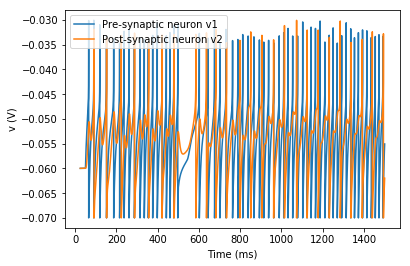

78.79000091552734


In [ ]:

d = time()
print('Paramètres de départ I1 = 160pa')
synapse_plot(0.31,0.001,0.1,0.2,0.5,-1)
f = time()
print(f-d)


In [ ]:
'''
print('Test I1')
i_const = 0*pA
synapse_plot(0.31,0.001,0.1,0.2,0.5,1)
i_const = -10*pA
synapse_plot(0.31,0.001,0.1,0.2,0.5,2)
i_const = -100*pA
synapse_plot(0.31,0.001,0.1,0.2,0.5,4)
i_const = -500*pA

print('Test alpha')
synapse_plot(0.31,0.1,0.1,0.2,0.5,6)
synapse_plot(0.31,10,0.1,0.2,0.5,7)
synapse_plot(0.31,1000,0.1,0.2,0.5,8)
synapse_plot(0.31,10000,0.1,0.2,0.5,9)
synapse_plot(0.31,100000,0.1,0.2,0.5,10)

print('Test beta')
synapse_plot(0.31,0.001,0.001,0.2,0.5,11)
synapse_plot(0.31,0.001,0.01,0.2,0.5,12)
synapse_plot(0.31,0.001,1,0.2,0.5,13)
synapse_plot(0.31,0.001,10,0.2,0.5,14)

print('Test gamma')
synapse_plot(0.31,0.001,0.1,0.002,0.5,15)
synapse_plot(0.31,0.001,0.1,0.02,0.5,16)
synapse_plot(0.31,0.001,0.1,2,0.5,17)
synapse_plot(0.31,0.001,0.1,20,0.5,18)

print('Test delta')
synapse_plot(0.31,0.001,0.1,0.2,0.05,50)
synapse_plot(0.31,0.001,0.1,0.2,0.2,51)
synapse_plot(0.31,0.001,0.1,0.2,0.8,52)
synapse_plot(0.31,0.001,0.1,0.2,1,53)

print('Test r')
synapse_plot(0.31,0.001,0.1,0.2,0.5,23)
synapse_plot(0.41,0.001,0.1,0.2,0.5,24)
synapse_plot(0.61,0.001,0.1,0.2,0.5,25)
synapse_plot(0.81,0.001,0.1,0.2,0.5,26)
synapse_plot(0.91,0.001,0.1,0.2,0.5,27)
'''


In [ ]:
#synapse_plot(0.31,0.001,0.1,0.2,0.5)

In [ ]:
lst = [10, 20, 25, 30, 40, 50, 60]


[30, 40, 50, 60]